In [1]:
# Cell 1: Import Libraries & Mount Drive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import pickle
import glob # Folder se files dhundne ke liye
import os

# Sklearn & Models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

import warnings
warnings.filterwarnings('ignore')

# Drive Mount
from google.colab import drive
try:
    drive.mount('/content/drive')
    print("Drive mounted successfully!")
except ValueError as e:
    print(f"Error mounting Google Drive: {e}")
    print("This often means you did not authorize access or there was a temporary issue. Please ensure you are logged into your Google account and authorize access when prompted. You might need to re-run this cell.")

print("Setup Complete!")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Drive mounted successfully!
Setup Complete!


-----

### Cell 2: Load Data from Folder (Updated)



In [2]:
# Cell 2: Load Multiple CSVs from Folder

folder_path = '/content/drive/MyDrive/IDS_DATASET/DATASET_DIR'

# Folder ke andar sari .csv files ki list banana
all_files = glob.glob(os.path.join(folder_path, "*.csv"))

print(f"Total files found: {len(all_files)}")

li = []
sample_frac = 0.2  # 20% data har file se lenge taki RAM full na ho (Change kar sakte ho)

for filename in all_files:
    print(f"Reading: {os.path.basename(filename)}...")
    try:
        df_temp = pd.read_csv(filename, index_col=None, header=0, encoding='cp1252')

        # Column names clean karte hain immediate
        df_temp.columns = df_temp.columns.str.strip()

        # Sampling (Randomly select x% of data)
        df_temp = df_temp.sample(frac=sample_frac, random_state=42)

        li.append(df_temp)
    except Exception as e:
        print(f"Error reading {filename}: {e}")

# Sabhi files ko jod kar ek bada dataset banana
df = pd.concat(li, axis=0, ignore_index=True)

print(f"\nFinal Combined Data Shape: {df.shape}")
df.head()

Total files found: 8
Reading: Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv...
Reading: Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv...
Reading: Friday-WorkingHours-Morning.pcap_ISCX.csv...
Reading: Monday-WorkingHours.pcap_ISCX.csv...
Reading: Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv...
Reading: Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv...
Reading: Tuesday-WorkingHours.pcap_ISCX.csv...
Reading: Wednesday-workingHours.pcap_ISCX.csv...

Final Combined Data Shape: (566149, 79)


,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,80,77689,4,8,6134,153,4686,0,1533.5,2209.736862,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,443,3659078,10,9,717,5821,363,0,71.7,121.708258,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,44176,76,1,1,2,6,2,2,2.0,0.000000,...,24,0.0,0.0,0,0,0.0,0.0,0,0,PortScan
3,8641,81,1,1,6,6,6,6,6.0,0.000000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,1026,61,1,1,2,6,2,2,2.0,0.000000,...,24,0.0,0.0,0,0,0.0,0.0,0,0,PortScan


-----

### Cell 3: Advanced Cleaning (Garbage Removal)

In [3]:
# Cell 3: Cleaning Infinity and NaN values

def clean_dataset(df):
    # 1. Replace Infinity with NaN
    df.replace([np.inf, -np.inf], np.nan, inplace=True)

    # 2. Check null
    print(f"Null values before: {df.isnull().sum().sum()}")

    # 3. Drop rows with NaN
    df.dropna(inplace=True)

    # 4. Remove Duplicates
    print(f"Duplicates before: {df.duplicated().sum()}")
    df.drop_duplicates(inplace=True)

    print(f"Shape after cleaning: {df.shape}")
    return df

df = clean_dataset(df)

Null values before: 1106
Duplicates before: 35374
Shape after cleaning: (530222, 79)


-----

### Cell 4: Feature Selection (Real-World Compatible)

वही features रखेंगे जो हम VS Code app में use करेंगे।

In [4]:
# Cell 4: Feature Selection

# Real-world compatible features list
selected_features = [
    'Destination Port', 'Flow Duration', 'Total Fwd Packets', 'Total Backward Packets',
    'Total Length of Fwd Packets', 'Total Length of Bwd Packets', 'Fwd Packet Length Max',
    'Fwd Packet Length Min', 'Fwd Packet Length Mean', 'Bwd Packet Length Max',
    'Bwd Packet Length Min', 'Bwd Packet Length Mean', 'Flow Bytes/s', 'Flow Packets/s',
    'Flow IAT Mean', 'Fwd IAT Mean', 'Bwd IAT Mean', 'Fwd Header Length',
    'Bwd Header Length', 'Fwd Flags', 'Bwd Packets/s', 'Min Packet Length',
    'Max Packet Length', 'Packet Length Mean', 'Average Packet Size',
    'Subflow Fwd Packets', 'Subflow Bwd Packets', 'Init_Win_bytes_forward',
    'Init_Win_bytes_backward', 'Label'
]

# Check if columns exist
existing_cols = [col for col in selected_features if col in df.columns]
df_final = df[existing_cols]

print(f"Final Features Selected: {len(existing_cols)}")

Final Features Selected: 29


-----

### Cell 5: Label Encoding & Splitting

In [5]:
# Cell 5: Encoding and Split

# Label Encoding
le = LabelEncoder()
df_final['Label'] = le.fit_transform(df_final['Label'])

print("Classes detected:", le.classes_)

# X and y
X = df_final.drop('Label', axis=1)
y = df_final['Label']

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print("Train/Test Split Done.")

Classes detected: ['BENIGN' 'Bot' 'DDoS' 'DoS GoldenEye' 'DoS Hulk' 'DoS Slowhttptest'
 'DoS slowloris' 'FTP-Patator' 'Heartbleed' 'Infiltration' 'PortScan'
 'SSH-Patator' 'Web Attack ï¿½ Brute Force' 'Web Attack ï¿½ Sql Injection'
 'Web Attack ï¿½ XSS']
Train/Test Split Done.


-----

### Cell 6: Scaling

In [6]:
# Cell 6: Scaling
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print("Scaling Done.")

Scaling Done.


-----

### Cell 7: Models (Random Forest)

In [7]:
# Cell 7: Random Forest
print("Training Random Forest...")
rf = RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1)
rf.fit(X_train_scaled, y_train)
print("RF Accuracy:", accuracy_score(y_test, rf.predict(X_test_scaled)))

Training Random Forest...
RF Accuracy: 0.9972275920599746


-----

### Cell 8: Models (XGBoost - Best for App)

Training XGBoost...
XGB Accuracy: 0.9982743175067188


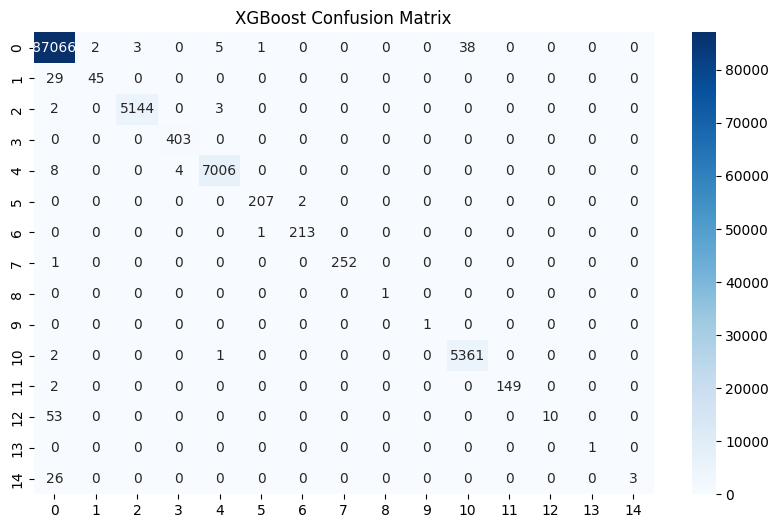

In [8]:
# Cell 8: XGBoost
print("Training XGBoost...")
xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
xgb.fit(X_train_scaled, y_train)
xgb_pred = xgb.predict(X_test_scaled)
print("XGB Accuracy:", accuracy_score(y_test, xgb_pred))

# Confusion Matrix
plt.figure(figsize=(10,6))
sns.heatmap(confusion_matrix(y_test, xgb_pred), annot=True, fmt='d', cmap='Blues')
plt.title("XGBoost Confusion Matrix")
plt.show()

-----

### Cell 9: LSTM (Deep Learning)

In [9]:
# Cell 9: LSTM
X_train_lstm = X_train_scaled.reshape(X_train_scaled.shape[0], 1, X_train_scaled.shape[1])
X_test_lstm = X_test_scaled.reshape(X_test_scaled.shape[0], 1, X_test_scaled.shape[1])

model = Sequential()
model.add(LSTM(64, input_shape=(1, X_train_scaled.shape[1]), activation='relu', return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(len(le.classes_), activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train_lstm, y_train, epochs=5, batch_size=64, validation_data=(X_test_lstm, y_test))

Epoch 1/5
6628/6628 ━━━━━━━━━━━━━━━━━━━━ 29s 4ms/step - accuracy: 0.8826 - loss: 0.5279 - val_accuracy: 0.9358 - val_loss: 0.1883
Epoch 2/5
6628/6628 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.9366 - loss: 0.1953 - val_accuracy: 0.9572 - val_loss: 0.1320
Epoch 3/5
6628/6628 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - accuracy: 0.9522 - loss: 0.1422 - val_accuracy: 0.9586 - val_loss: 0.1204
Epoch 4/5
6628/6628 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.9571 - loss: 0.1220 - val_accuracy: 0.9641 - val_loss: 0.0982
Epoch 5/5
6628/6628 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - accuracy: 0.9598 - loss: 0.1099 - val_accuracy: 0.9665 - val_loss: 0.0885


Cell 10: Advanced Visualization Functions

In [10]:
# Cell 10: Define Plotting Functions (ROC & Confusion Matrix)

from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc, precision_recall_fscore_support

# 1. Function for Confusion Matrix
def plot_cm(y_true, y_pred, title, classes):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(12, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.xticks(rotation=45)
    plt.show()

# 2. Function for Multi-class ROC Curve
def plot_multiclass_roc(model, X_test, y_test, n_classes, classes, model_name, is_lstm=False):
    # Binarize the output for ROC calculation
    y_test_bin = label_binarize(y_test, classes=range(n_classes))

    # Get probabilities
    if is_lstm:
        y_score = model.predict(X_test)
    else:
        y_score = model.predict_proba(X_test)

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    plt.figure(figsize=(10, 8))

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        plt.plot(fpr[i], tpr[i], lw=2, label=f'Class {classes[i]} (area = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model_name}')
    plt.legend(loc="lower right", fontsize='small', ncol=2) # Legend adjust kiya
    plt.show()

print("Visualization Functions Defined!")

Visualization Functions Defined!


Cell 11: Generate Plots for All Models


Generating Random Forest Plots...


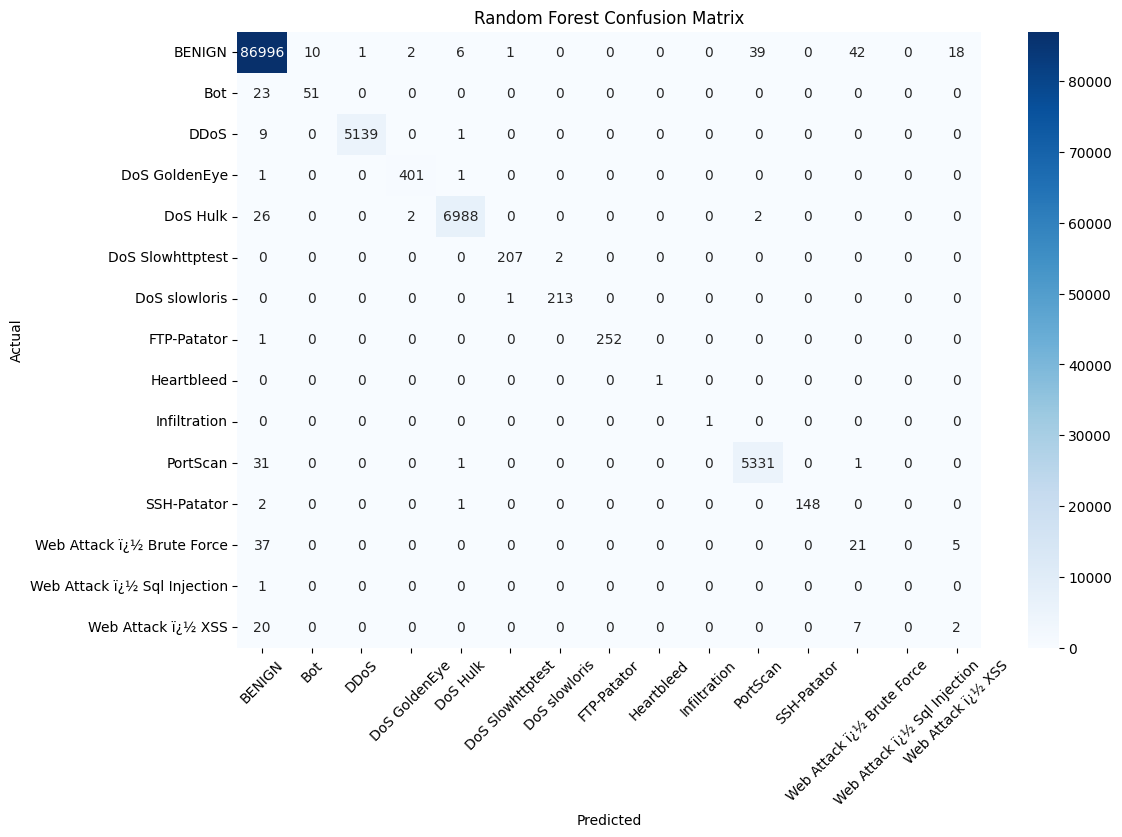

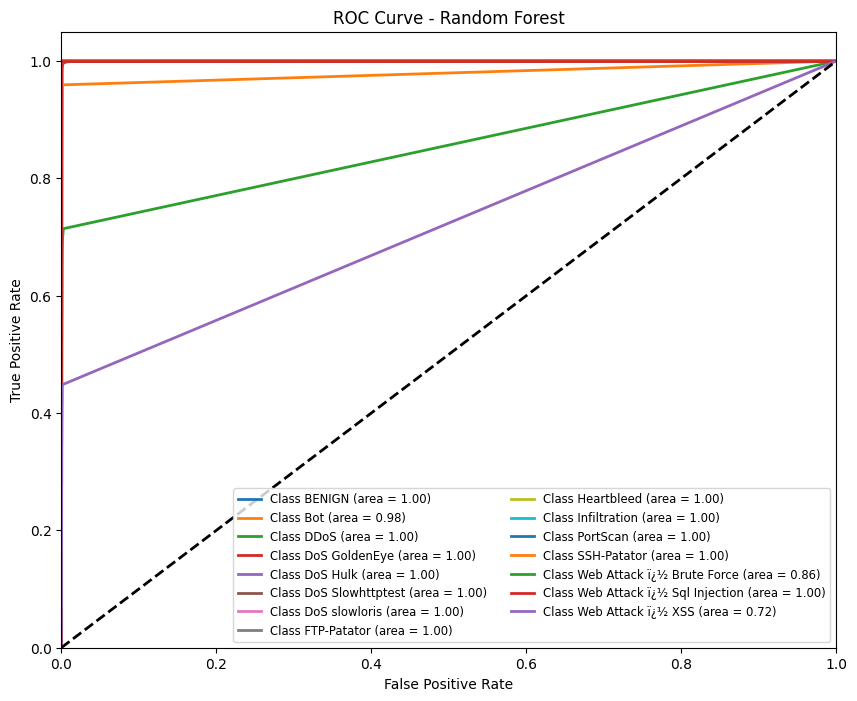


Generating XGBoost Plots...


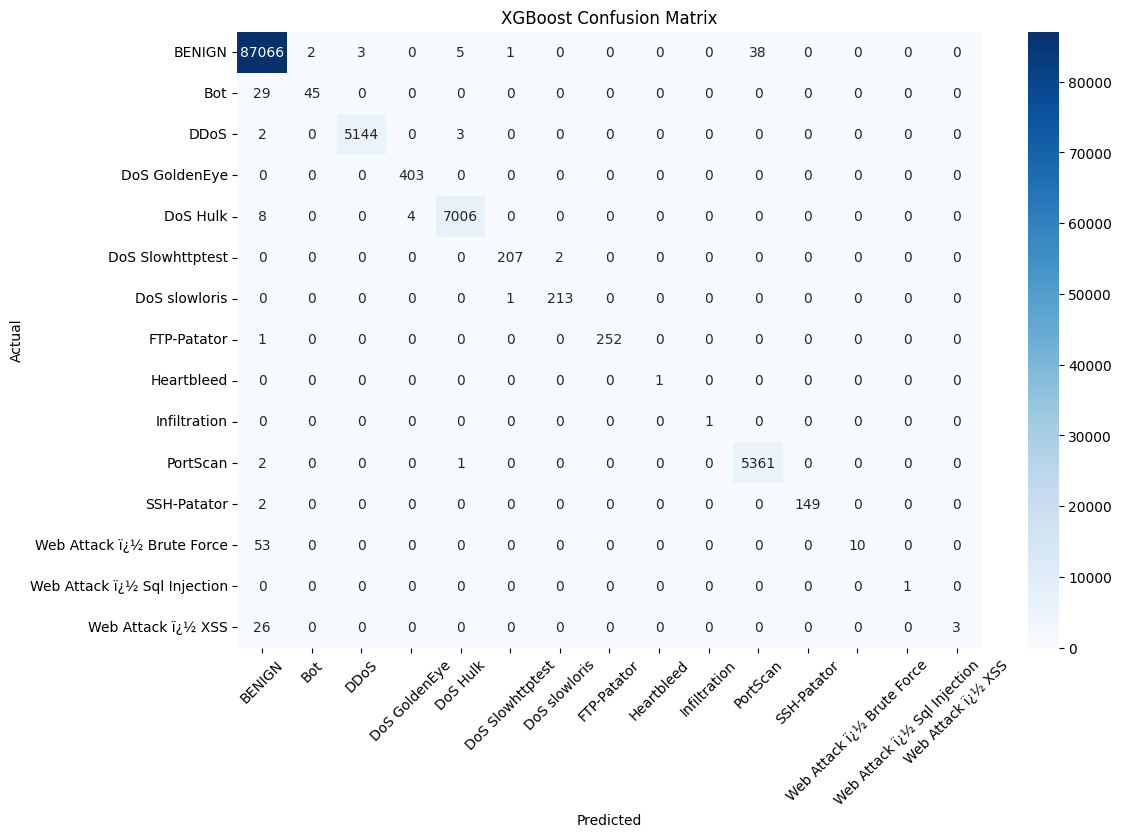

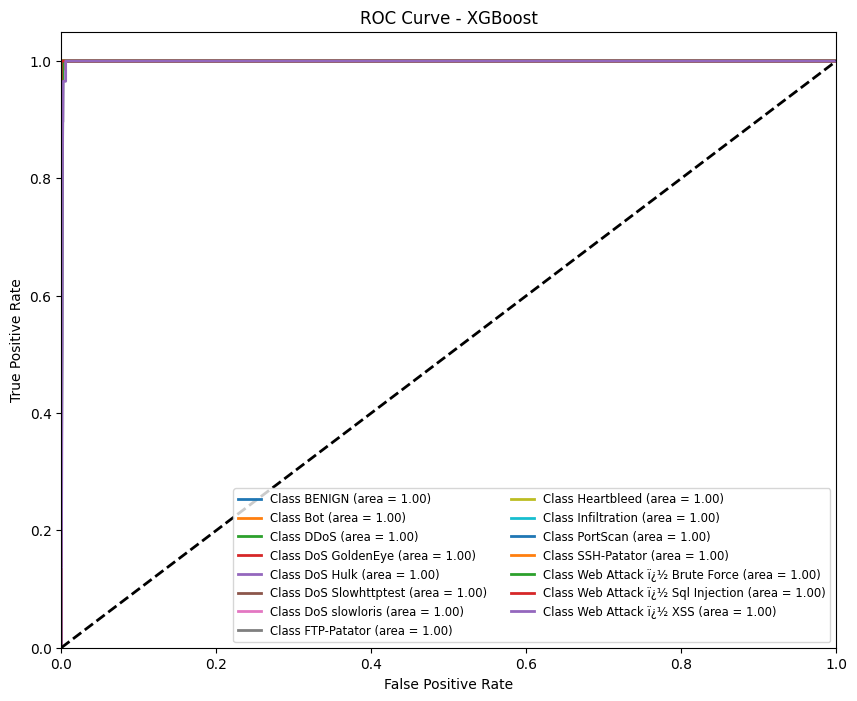


Generating LSTM Plots...
3314/3314 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step


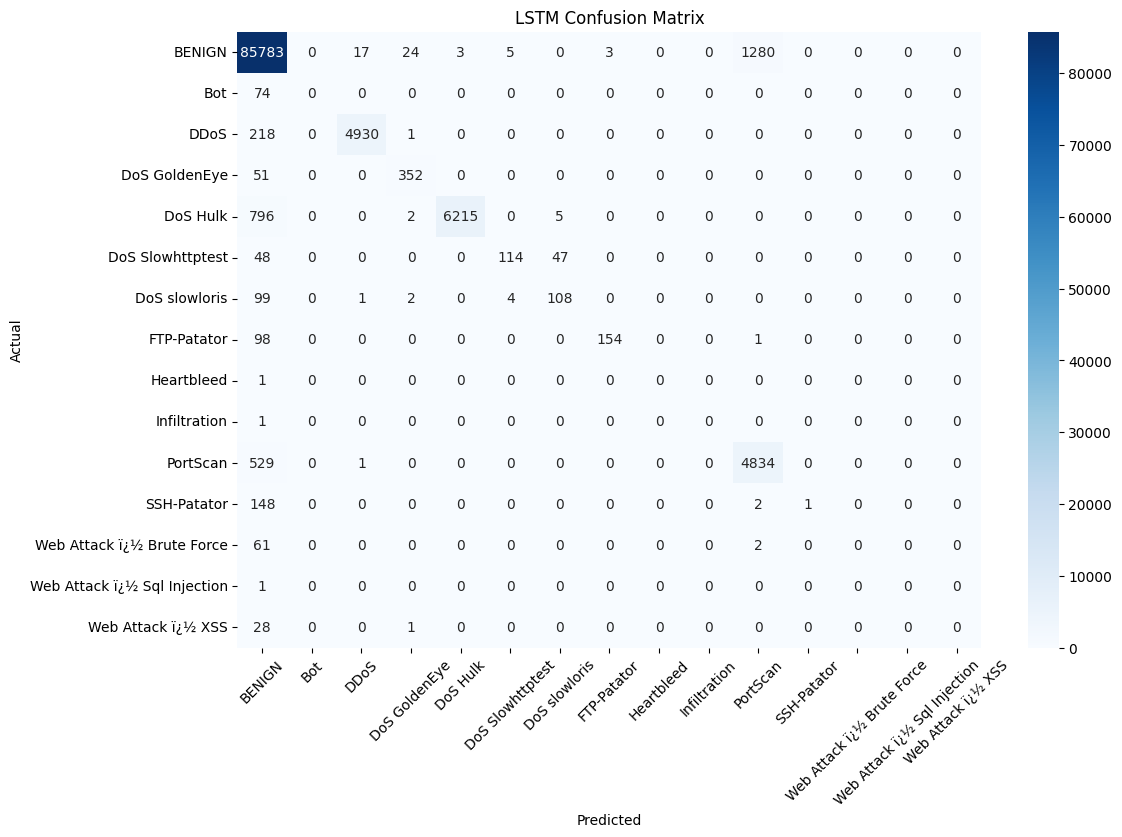

3314/3314 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step


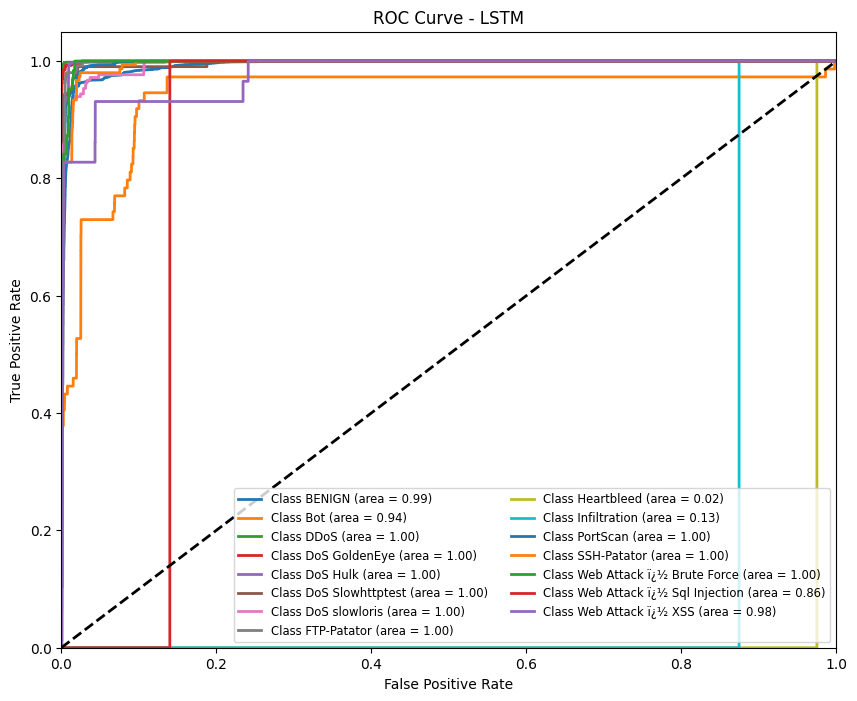

In [11]:
# Cell 11: Generate Plots

class_names = le.classes_
n_classes = len(class_names)

# --- 1. Random Forest Visuals ---
print("\nGenerating Random Forest Plots...")
rf_pred = rf.predict(X_test_scaled)
plot_cm(y_test, rf_pred, "Random Forest Confusion Matrix", class_names)
plot_multiclass_roc(rf, X_test_scaled, y_test, n_classes, class_names, "Random Forest")

# --- 2. XGBoost Visuals ---
print("\nGenerating XGBoost Plots...")
xgb_pred = xgb.predict(X_test_scaled)
plot_cm(y_test, xgb_pred, "XGBoost Confusion Matrix", class_names)
plot_multiclass_roc(xgb, X_test_scaled, y_test, n_classes, class_names, "XGBoost")

# --- 3. LSTM Visuals ---
print("\nGenerating LSTM Plots...")
# LSTM prediction returns probabilities, need argmax for confusion matrix
lstm_pred_prob = model.predict(X_test_lstm)
lstm_pred = np.argmax(lstm_pred_prob, axis=1)

plot_cm(y_test, lstm_pred, "LSTM Confusion Matrix", class_names)
plot_multiclass_roc(model, X_test_lstm, y_test, n_classes, class_names, "LSTM", is_lstm=True)

Cell 12: Model Comparison (Bar Charts)


--- Model Comparison Table ---
           Model  Accuracy  Precision    Recall  F1-Score
0  Random Forest  0.997228   0.997218  0.997228  0.997216
1        XGBoost  0.998274   0.998267  0.998274  0.997962
2           LSTM  0.966486   0.966308  0.966486  0.965022


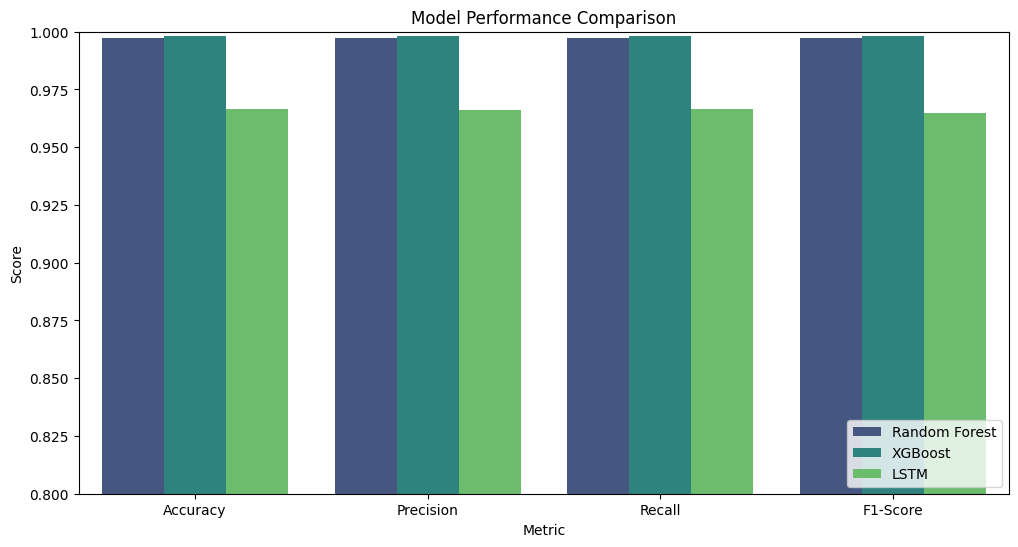

In [12]:
# Cell 12: Model Comparison Table & Bar Charts

# Calculate Metrics for all models
def get_metrics(y_true, y_pred, model_name):
    acc = accuracy_score(y_true, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')
    return [model_name, acc, precision, recall, f1]

metrics_data = []
metrics_data.append(get_metrics(y_test, rf_pred, 'Random Forest'))
metrics_data.append(get_metrics(y_test, xgb_pred, 'XGBoost'))
metrics_data.append(get_metrics(y_test, lstm_pred, 'LSTM'))

# Create DataFrame
comp_df = pd.DataFrame(metrics_data, columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score'])

print("\n--- Model Comparison Table ---")
print(comp_df)

# Plotting Comparison
plt.figure(figsize=(12, 6))
# Melt dataframe for sns barplot
df_melted = comp_df.melt(id_vars="Model", var_name="Metric", value_name="Score")

sns.barplot(x='Metric', y='Score', hue='Model', data=df_melted, palette='viridis')
plt.title("Model Performance Comparison")
plt.ylim(0.8, 1.0) # Zoom in to see difference (adjust if accuracy is lower)
plt.ylabel("Score")
plt.legend(loc='lower right')
plt.show()

In [13]:
# Cell 13: Save Final Artifacts to Google Drive Folder
import os

# Apka Drive Folder Path
save_path = '/content/drive/MyDrive/IDS_DATASET/'

# Agar folder exist nahi karta to create karega (Safety ke liye)
if not os.path.exists(save_path):
    os.makedirs(save_path)
    print(f"Directory created: {save_path}")

print(f"Saving models to: {save_path} ...")

# 1. Save Scaler
joblib.dump(scaler, os.path.join(save_path, 'scaler.pkl'))

# 2. Save Label Encoder
joblib.dump(le, os.path.join(save_path, 'label_encoder.pkl'))

# 3. Save XGBoost Model (Best for App)
joblib.dump(xgb, os.path.join(save_path, 'xgb_model.pkl'))

# 4. Save LSTM Model (HDF5 format)
model.save(os.path.join(save_path, 'lstm_model.h5'))

# 5. Save Feature List
feature_list = list(X.columns)
with open(os.path.join(save_path, 'features.pkl'), 'wb') as f:
    pickle.dump(feature_list, f)

print("\nSuccess! All files are saved in your Drive folder.")
print(f"Check here: {save_path}")

Saving models to: /content/drive/MyDrive/IDS_DATASET/ ...

Success! All files are saved in your Drive folder.
Check here: /content/drive/MyDrive/IDS_DATASET/
